In [1]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [2]:
name = "overdamped_k15"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
overdamped_name = f"model_{name}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

15 True True False [128, 128, 256]


### Problem definition

In [3]:
N = 512
t_span = (0, 12)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [4]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [5]:
w_list_transfer = [1, 1, 1, 1, 1]
zeta_list = [5, 10, 30, 60]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.cos(t)
ic_list = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
epsilon_list = [0.5, 0.5, 0.5, 0.5, 0.5]
p_list = [6]
q = [(3, 1)]

### Numerical solver

In [6]:
numerical_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [7]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [8]:
NN_TL_solution.shape

(512, 4, 2)

In [9]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 5, order: 0, mean error absolute: 0.07055121781346871
zeta: 5, order: 1, mean error absolute: 0.017410618760703368
zeta: 5, order: 2, mean error absolute: 0.0054893211203902005
zeta: 5, order: 3, mean error absolute: 0.0018069299903771868
zeta: 5, order: 4, mean error absolute: 0.0007636619399403547
zeta: 5, order: 5, mean error absolute: 0.0002813414917402931


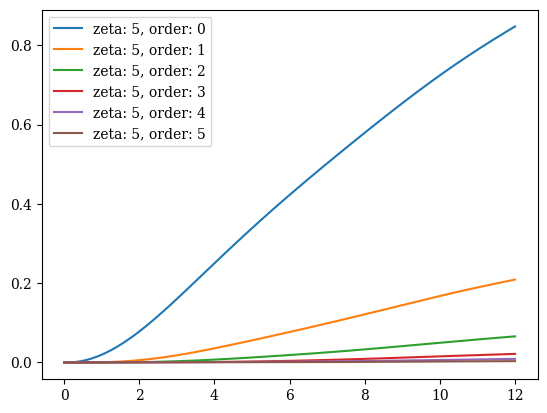

zeta: 10, order: 0, mean error absolute: 0.06360238864901999
zeta: 10, order: 1, mean error absolute: 0.011265324863168226
zeta: 10, order: 2, mean error absolute: 0.002645493167183344
zeta: 10, order: 3, mean error absolute: 0.0005755163551435114
zeta: 10, order: 4, mean error absolute: 0.00027393979833431387
zeta: 10, order: 5, mean error absolute: 7.229678254485716e-05


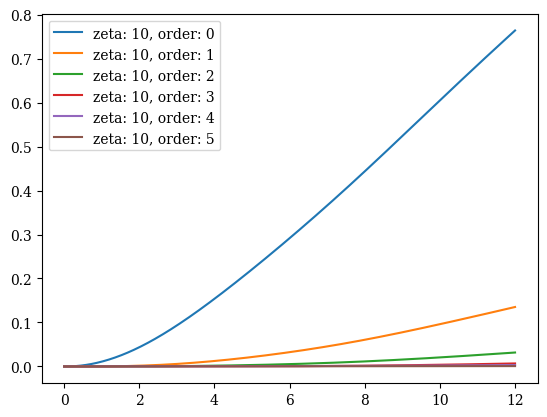

zeta: 30, order: 0, mean error absolute: 0.03599522613556422
zeta: 30, order: 1, mean error absolute: 0.003007208160740559
zeta: 30, order: 2, mean error absolute: 0.0002957054387783865
zeta: 30, order: 3, mean error absolute: 8.841582154312986e-05
zeta: 30, order: 4, mean error absolute: 6.589434680196447e-05
zeta: 30, order: 5, mean error absolute: 6.679177974572574e-05


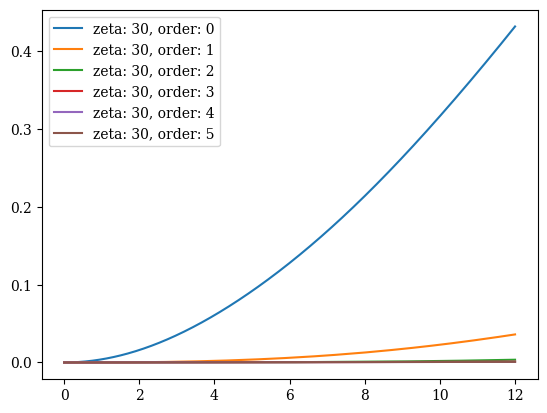

zeta: 60, order: 0, mean error absolute: 0.02107062559933203
zeta: 60, order: 1, mean error absolute: 0.0010500416272597385
zeta: 60, order: 2, mean error absolute: 6.979660823254355e-05
zeta: 60, order: 3, mean error absolute: 9.31402247818945e-05
zeta: 60, order: 4, mean error absolute: 8.94296275099429e-05
zeta: 60, order: 5, mean error absolute: 8.96835130594683e-05


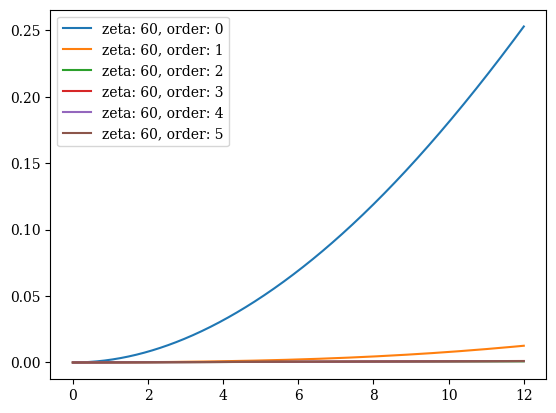

In [10]:
standard.plot_error_by_order(t_eval, PINN_solution, numerical_list, p_list, zeta_list, "zeta")

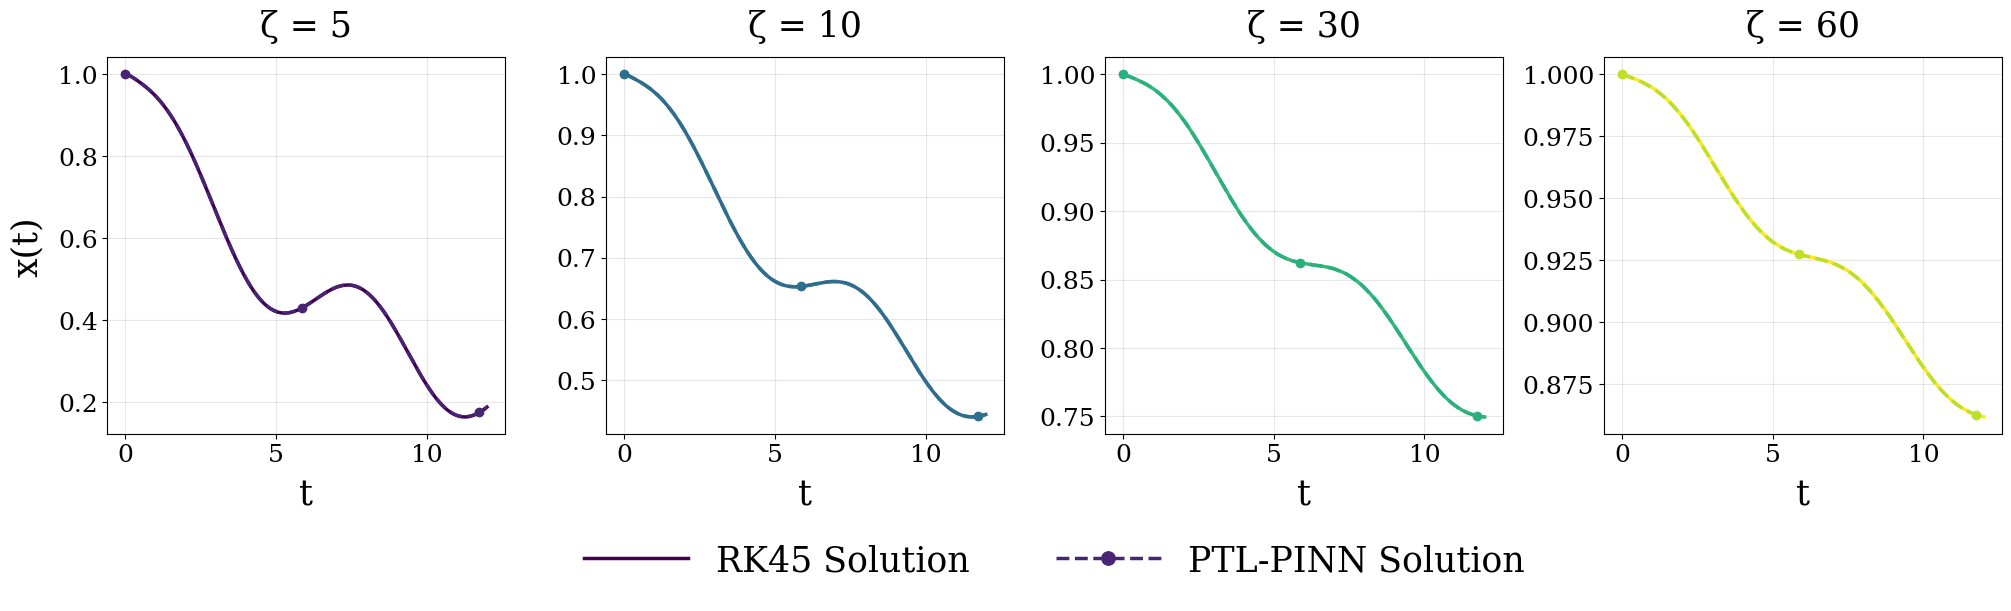

In [11]:
standard.plot_compare_multiple_zeta(t_eval, zeta_list, numerical_list, NN_TL_solution)


zeta: 5, mean Error: 1.881e-04
zeta: 10, mean Error: 1.185e-04
zeta: 30, mean Error: 6.663e-05
zeta: 60, mean Error: 8.967e-05


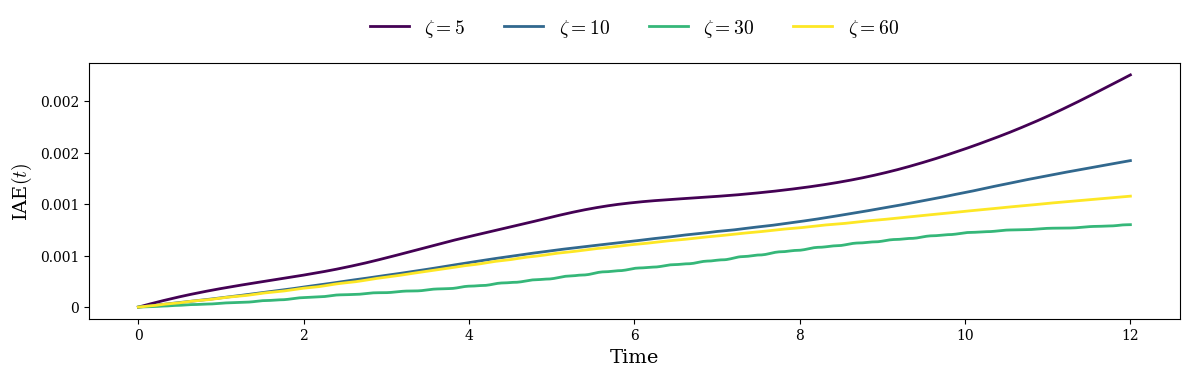

In [12]:
standard.plot_IAE_multiple_zeta(zeta_list, t_eval, NN_TL_solution, numerical_list)

/tmp/ipykernel_14870/2572481309.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


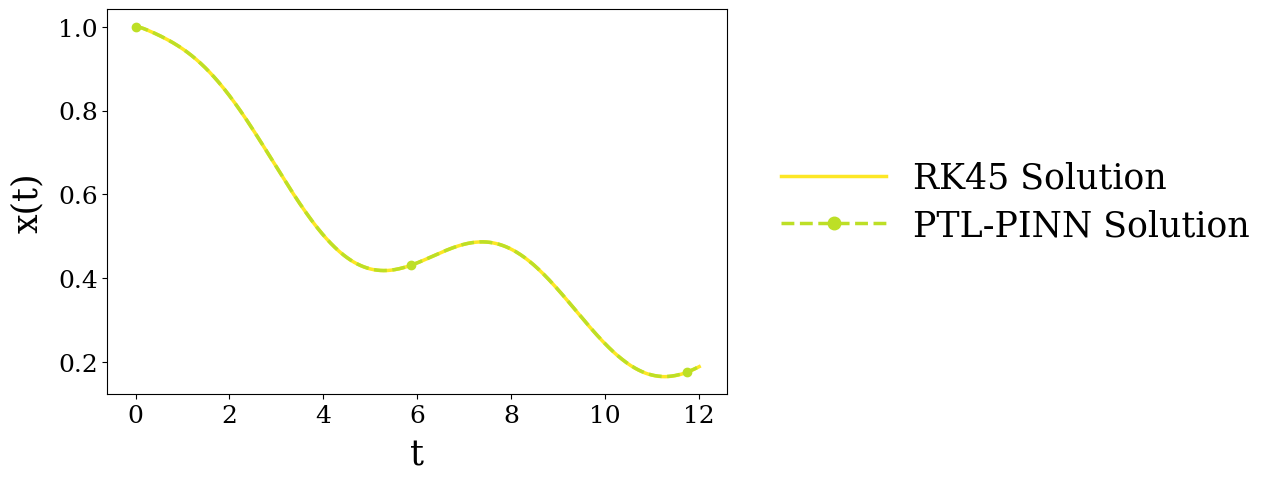

In [ ]:
import matplotlib.cm as cm

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

def plot_solution(t_eval, y_num, y_nn, i = 3):
    title_fs  = 25
    label_fs  = 25
    tick_fs   = 18
    legend_fs = 25
    cmap = cm.get_cmap("viridis", 3)

    fig, ax = plt.subplots(figsize=(8, 5))

    base_color = cmap(i / 2)
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * i / 2)

    ax.plot(t_eval, y_num,
            label="RK45 Solution",
            color=rk_color, linewidth=2.5)

    ax.plot(t_eval, y_nn,
            label="PTL-PINN Solution",
            color=pinn_color, linewidth=2.5,
            linestyle="--", marker="o", markevery=250)

    ax.set_xlabel("t", fontsize=label_fs, labelpad=8)
    ax.set_ylabel("x(t)", fontsize=label_fs, labelpad=10)

    ax.tick_params(axis='both', labelsize=tick_fs)

    # Set y-limits with padding
    y_min = min(np.min(y_num), np.min(y_nn))
    y_max = max(np.max(y_num), np.max(y_nn))
    pad = 0.05 * max(1e-12, (y_max - y_min))
    ax.set_ylim(y_min - pad, y_max + pad)

    ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # (x, y): anchor the legend outside the right border
    fontsize=legend_fs,
    frameon=False,
    handlelength=3.0,
    markerscale=1.5,
    labelspacing=0.4,
    borderaxespad=0.8)
    plt.show()

plot_solution(t_eval, numerical_list[0][0, :], NN_TL_solution[:, 0, 0], i = 2)